In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
import IPython.display as display
from PIL import Image
import time

In [5]:
def load_and_process_img(path_to_img):
    max_dim = 512
    img = load_img(path_to_img)
    img = img_to_array(img)
    img = tf.image.resize(img, (max_dim, max_dim))
    img = preprocess_input(img)
    return np.expand_dims(img, axis=0)

def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    assert len(x.shape) == 3, "Input to deprocess image must be an image of dimension [1, height, width, channel] or [height, width, channel]"
    if len(x.shape) != 3:
        raise ValueError("Invalid input to deprocessing image")

    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]

    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [6]:
def get_model(style_layers, content_layers):
    vgg = VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    style_outputs = [vgg.get_layer(name).output for name in style_layers]
    content_outputs = [vgg.get_layer(name).output for name in content_layers]
    model_outputs = style_outputs + content_outputs

    return Model(vgg.input, model_outputs)

content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

In [7]:
def get_content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

def gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):
    height, width, channels = base_style.get_shape().as_list()
    gram_style = gram_matrix(base_style)

    return tf.reduce_mean(tf.square(gram_style - gram_target))

In [8]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    style_weight, content_weight = loss_weights

    model_outputs = model(init_image)

    style_output_features = model_outputs[:len(style_layers)]
    content_output_features = model_outputs[len(style_layers):]

    style_score = 0
    content_score = 0

    weight_per_style_layer = 1.0 / float(len(style_layers))
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)

    weight_per_content_layer = 1.0 / float(len(content_layers))
    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += weight_per_content_layer * get_content_loss(comb_content[0], target_content)

    style_score *= style_weight
    content_score *= content_weight

    total_loss = style_score + content_score
    return total_loss, style_score, content_score

In [9]:
def compute_grads(cfg):
    with tf.GradientTape() as tape:
        all_loss = compute_loss(**cfg)
    total_loss = all_loss[0]
    return tape.gradient(total_loss, cfg['init_image']), all_loss

In [12]:
def run_style_transfer(content_path, style_path, num_iterations=30, content_weight=1e3, style_weight=1e-2):
    model = get_model(style_layers, content_layers)
    for layer in model.layers:
        layer.trainable = False

    content_image = load_and_process_img(content_path)
    style_image = load_and_process_img(style_path)

    style_outputs = model(style_image)
    content_outputs = model(content_image)

    style_features = [style_layer[0] for style_layer in style_outputs[:len(style_layers)]]
    content_features = [content_layer[0] for content_layer in content_outputs[len(style_layers):]]

    init_image = tf.Variable(content_image, dtype=tf.float32)
    opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

    iter_count = 1

    best_loss, best_img = float('inf'), None

    loss_weights = (style_weight, content_weight)

    cfg = {
        'model': model,
        'loss_weights': loss_weights,
        'init_image': init_image,
        'gram_style_features': [gram_matrix(style_feature) for style_feature in style_features],
        'content_features': content_features
    }

    num_rows = 2
    num_cols = 5
    display_interval = num_iterations / (num_rows * num_cols)
    start_time = time.time()
    global_start = time.time()

    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means

    imgs = []
    for i in range(num_iterations):
        grads, all_loss = compute_grads(cfg)
        loss, style_score, content_score = all_loss
        opt.apply_gradients([(grads, init_image)])
        clipped = tf.clip_by_value(init_image, min_vals, max_vals)
        init_image.assign(clipped)
        if loss < best_loss:
            best_loss = loss
            best_img = deprocess_img(init_image.numpy())

        if i % display_interval == 0:
            start_time = time.time()

        print('Iteration: {}'.format(i))
        print('Total loss: {:.4e}, '
              'style loss: {:.4e}, '
              'content loss: {:.4e}, '
              'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
    print('Total time: {:.4f}s'.format(time.time() - global_start))
    return best_img, best_loss

content_path = '/content/Golden_Gate.jpg'
style_path = '/content/Van.jpg'

best, best_loss = run_style_transfer(content_path, style_path, num_iterations=30)

Iteration: 0
Total loss: 1.6541e+08, style loss: 1.6541e+08, content loss: 0.0000e+00, time: 0.0001s
Iteration: 1
Total loss: 1.6461e+08, style loss: 1.6461e+08, content loss: 7.2562e+01, time: 20.6393s
Iteration: 2
Total loss: 1.6380e+08, style loss: 1.6380e+08, content loss: 2.9478e+02, time: 35.0460s
Iteration: 3
Total loss: 1.6298e+08, style loss: 1.6298e+08, content loss: 6.7272e+02, time: 0.0001s
Iteration: 4
Total loss: 1.6216e+08, style loss: 1.6216e+08, content loss: 1.2081e+03, time: 14.2519s
Iteration: 5
Total loss: 1.6133e+08, style loss: 1.6133e+08, content loss: 1.9034e+03, time: 28.5721s
Iteration: 6
Total loss: 1.6050e+08, style loss: 1.6050e+08, content loss: 2.7587e+03, time: 0.0001s
Iteration: 7
Total loss: 1.5968e+08, style loss: 1.5967e+08, content loss: 3.7781e+03, time: 17.3954s
Iteration: 8
Total loss: 1.5885e+08, style loss: 1.5884e+08, content loss: 4.9598e+03, time: 31.3935s
Iteration: 9
Total loss: 1.5802e+08, style loss: 1.5802e+08, content loss: 6.3031e+03

In [13]:
plt.imshow(best_img)
plt.show()

NameError: name 'best_img' is not defined

Iteration: 0
Total loss: 1.6541e+08, style loss: 1.6541e+08, content loss: 0.0000e+00, time: 0.0001s
Iteration: 1
Total loss: 1.6461e+08, style loss: 1.6461e+08, content loss: 7.2562e+01, time: 14.1312s
Iteration: 2
Total loss: 1.6380e+08, style loss: 1.6380e+08, content loss: 2.9478e+02, time: 0.0003s
Iteration: 3
Total loss: 1.6298e+08, style loss: 1.6298e+08, content loss: 6.7272e+02, time: 14.1936s
Iteration: 4
Total loss: 1.6216e+08, style loss: 1.6216e+08, content loss: 1.2081e+03, time: 0.0005s
Iteration: 5
Total loss: 1.6133e+08, style loss: 1.6133e+08, content loss: 1.9034e+03, time: 14.3977s
Iteration: 6
Total loss: 1.6050e+08, style loss: 1.6050e+08, content loss: 2.7587e+03, time: 0.0002s
Iteration: 7
Total loss: 1.5968e+08, style loss: 1.5967e+08, content loss: 3.7781e+03, time: 14.0035s
Iteration: 8
Total loss: 1.5885e+08, style loss: 1.5884e+08, content loss: 4.9598e+03, time: 0.0001s
Iteration: 9
Total loss: 1.5802e+08, style loss: 1.5802e+08, content loss: 6.3031e+03, 

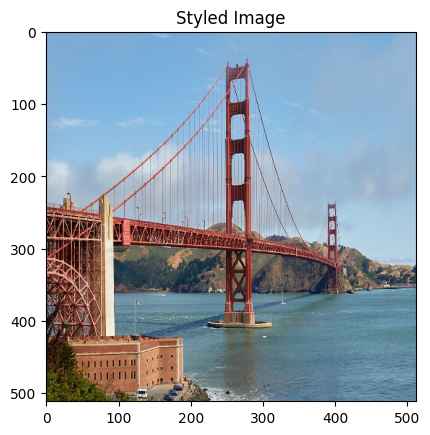

In [14]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
import time

# Load and preprocess images
def load_and_process_img(path_to_img):
    max_dim = 512
    img = load_img(path_to_img)
    img = img_to_array(img)
    img = tf.image.resize(img, (max_dim, max_dim))
    img = preprocess_input(img)
    return np.expand_dims(img, axis=0)

def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    assert len(x.shape) == 3, "Input to deprocess image must be an image of dimension [1, height, width, channel] or [height, width, channel]"
    if len(x.shape) != 3:
        raise ValueError("Invalid input to deprocessing image")

    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]

    x = np.clip(x, 0, 255).astype('uint8')
    return x

# Load VGG19 model and define content and style layers
def get_model(style_layers, content_layers):
    vgg = VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    style_outputs = [vgg.get_layer(name).output for name in style_layers]
    content_outputs = [vgg.get_layer(name).output for name in content_layers]
    model_outputs = style_outputs + content_outputs

    return Model(vgg.input, model_outputs)

content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

# Define the style and content loss functions
def get_content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

def gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):
    height, width, channels = base_style.get_shape().as_list()
    gram_style = gram_matrix(base_style)

    return tf.reduce_mean(tf.square(gram_style - gram_target))

# Compute the total loss
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    style_weight, content_weight = loss_weights

    model_outputs = model(init_image)

    style_output_features = model_outputs[:len(style_layers)]
    content_output_features = model_outputs[len(style_layers):]

    style_score = 0
    content_score = 0

    weight_per_style_layer = 1.0 / float(len(style_layers))
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)

    weight_per_content_layer = 1.0 / float(len(content_layers))
    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += weight_per_content_layer * get_content_loss(comb_content[0], target_content)

    style_score *= style_weight
    content_score *= content_weight

    total_loss = style_score + content_score
    return total_loss, style_score, content_score

# Compute gradients and optimize
def compute_grads(cfg):
    with tf.GradientTape() as tape:
        all_loss = compute_loss(**cfg)
    total_loss = all_loss[0]
    return tape.gradient(total_loss, cfg['init_image']), all_loss

# Run the style transfer
def run_style_transfer(content_path, style_path, num_iterations=20, content_weight=1e3, style_weight=1e-2):
    model = get_model(style_layers, content_layers)
    for layer in model.layers:
        layer.trainable = False

    content_image = load_and_process_img(content_path)
    style_image = load_and_process_img(style_path)

    style_outputs = model(style_image)
    content_outputs = model(content_image)

    style_features = [style_layer[0] for style_layer in style_outputs[:len(style_layers)]]
    content_features = [content_layer[0] for content_layer in content_outputs[len(style_layers):]]

    init_image = tf.Variable(content_image, dtype=tf.float32)
    opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

    iter_count = 1

    best_loss, best_img = float('inf'), None

    loss_weights = (style_weight, content_weight)

    cfg = {
        'model': model,
        'loss_weights': loss_weights,
        'init_image': init_image,
        'gram_style_features': [gram_matrix(style_feature) for style_feature in style_features],
        'content_features': content_features
    }

    num_rows = 2
    num_cols = 5
    display_interval = num_iterations / (num_rows * num_cols)
    start_time = time.time()
    global_start = time.time()

    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means

    imgs = []
    for i in range(num_iterations):
        grads, all_loss = compute_grads(cfg)
        loss, style_score, content_score = all_loss
        opt.apply_gradients([(grads, init_image)])
        clipped = tf.clip_by_value(init_image, min_vals, max_vals)
        init_image.assign(clipped)
        if loss < best_loss:
            best_loss = loss
            best_img = deprocess_img(init_image.numpy())

        if i % display_interval == 0:
            start_time = time.time()

        print('Iteration: {}'.format(i))
        print('Total loss: {:.4e}, '
              'style loss: {:.4e}, '
              'content loss: {:.4e}, '
              'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
    print('Total time: {:.4f}s'.format(time.time() - global_start))
    return best_img, best_loss

# Paths to your content and style images
content_path = '/content/Golden_Gate.jpg'
style_path = '/content/Van.jpg'

# Run the style transfer
best_img, best_loss = run_style_transfer(content_path, style_path, num_iterations=20)

# Display the result
plt.imshow(best_img)
plt.title('Styled Image')
plt.show()